## Reconstruct MNIST with AutoEncoder 


### Import Packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms,datasets

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

print('pytorch version:',torch.__version__,
      '\ntorchvision version: ',torchvision.__version__,
      '\nnumpy version:' ,np.__version__,
      '\nmatplotlib version: ',matplotlib.__version__)

pytorch version: 1.5.0 
torchvision version:  0.6.0a0+82fd1c8 
numpy version: 1.17.2 
matplotlib version:  3.1.1


### Settings

In [2]:
# model runs on  GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 1e-3 
num_epochs = 100
batch_size = 64

### Dataset: MNIST


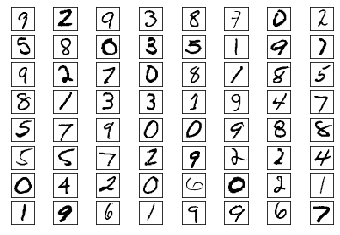

In [3]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.Compose([
                                    transforms.ToTensor(),
                                ]),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.Compose([
                                    transforms.ToTensor(),
                                ]))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

x, _ = iter(train_loader).next()
x_hat = x.view(batch_size, 28, 28).cpu()
plt.figure()
for i in range(1, batch_size + 1):
    plt.subplot(8, int(batch_size / 8), i)
    plt.imshow(x_hat[i-1], cmap='Greys')
    plt.xticks([])
    plt.yticks([])
plt.show()

### Define AE

In [4]:
class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()
        # [b, 784] => [b, 20]
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 20),
            nn.ReLU()
        )
        # [b, 20] => [b, 784]
        self.decoder = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        # flatten
        x = x.view(x.size(0), 784)
        # encoder
        x = self.encoder(x)
        # decoder
        x = self.decoder(x)
        # reshape
        x = x.view(x.size(0), 1, 28, 28)

        return x
    

### Init AE, define optimizer and loss function

In [5]:
model = AE()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criteon = nn.MSELoss().to(device)

### Training AE

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.231824
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.046222
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.032876
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.031048
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.029187
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.025726
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.022002
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.022970
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023525
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.021604
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.021603
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.020718
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019956
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.019347
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.018571
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.020196
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.018565
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.018994
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.018887
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.020296
Train Epoch: 5 [0/60000 (

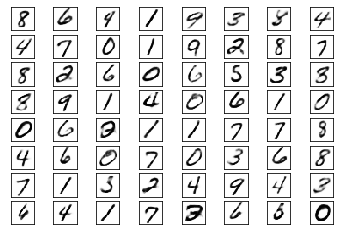

In [6]:
# %matplotlib inline

raw = []
result = []

for epoch in range(num_epochs):

    model.train()
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        
        # forward
        x_hat = model(x) # x_hat is the image reconstructed by the model
        loss = criteon(x_hat, x)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 300 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
    
    model.eval()
    with torch.no_grad():
        for x, _ in test_loader:
            raw.append(x)
            x = x.to(device)
            x_hat = model(x)
            result.append(x_hat)

print("------------------Raw Image-------------------")
x = raw[-2].view(batch_size, 28, 28).cpu()
plt.figure()
for i in range(1, batch_size + 1):
    plt.subplot(8, int(batch_size / 8), i)
    plt.imshow(x[i-1], cmap='Greys')
    plt.xticks([])
    plt.yticks([])
plt.show()

print("-------------Reconstruction Image-------------")
x_hat = result[-2].view(batch_size, 28, 28).cpu()
plt.figure()
for i in range(1, batch_size + 1):
    plt.subplot(8, int(batch_size / 8), i)
    plt.imshow(x_hat[i-1], cmap='Greys')
    plt.xticks([])
    plt.yticks([])
plt.show()